In [ ]:
# Import Libraries
import kagglehub
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, LayerNormalization, Dropout, GlobalAveragePooling1D, Dense, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.activations import gelu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
# Configuration
class Config:
    seed = 2021
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

config = Config()
seed_everything(config.seed)

In [ ]:
# Load Datasets
# MIT-BIH Dataset
df_mitbih_train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

In [ ]:
# PTB Dataset
df_ptbdb = pd.read_csv('/kaggle/input/heartbeat/ptbdb_abnormal.csv', header=None)
df_ptbdb.rename(columns={187: 'class'}, inplace=True)  # Rename last column to 'class'

In [ ]:
# Map MIT-BIH Classes
id_to_label_mitbih = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih['class'].map(id_to_label_mitbih)

# Preprocess Datasets
df_ptbdb_features = df_ptbdb.iloc[:, :187]  # 187 feature columns # Moved this line up

# Map PTB Classes
df_ptbdb['class'] = df_ptbdb_features.iloc[:,-1].apply(lambda x: 0 if x == 0 else 5)  # Using ptbdb_features instead, since it contains the original 'class'
df_ptbdb['label'] = df_ptbdb['class'].map({0: "Normal", 5: "PTB Abnormal"})


# Create a DataFrame with features, class, and label
df_ptbdb.columns = [f'feature_{i}' for i in range(187)] + ['class', 'label'] # rename columns to include feature_0 to feature_186, class, and label

# Ensure MIT-BIH has consistent columns
df_mitbih_features = df_mitbih.iloc[:, :187]  # 187 feature columns

df_mitbih.columns = [f'feature_{i}' for i in range(187)] + ['class', 'label'] # rename columns to include feature_0 to feature_186, class, and label


# Combine Datasets
df_combined = pd.concat([df_mitbih, df_ptbdb], axis=0, ignore_index=True)

# Save combined dataset
df_combined.to_csv('data_combined.csv', index=False)

In [ ]:
# EDA
print("Class Distribution Before SMOTE:")
print(df_combined['label'].value_counts())

# Apply SMOTE for Class Balancing
X = df_combined.iloc[:, :187].values
y = df_combined['class'].values

# Impute or drop NaN values in X
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

smote = SMOTE(random_state=config.seed)
X_resampled, y_resampled = smote.fit_resample(X, y)

Class Distribution Before SMOTE:
label
Normal                               90589
PTB Abnormal                         10506
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: count, dtype: int64


In [ ]:
# Create DataFrame with resampled data
id_to_label = {
    0: "Normal",
    1: "Atrial Premature",
    2: "Premature Ventricular Contraction",
    3: "Fusion of Ventricular and Normal",
    4: "Fusion of Paced and Normal",
    5: "PTB Abnormal"
}
df_resampled = pd.DataFrame(X_resampled, columns=[f'feature_{i}' for i in range(187)])
df_resampled['class'] = y_resampled
df_resampled['label'] = df_resampled['class'].map(id_to_label)

# Save resampled dataset
df_resampled.to_csv('data_combined_synthetic.csv', index=False)

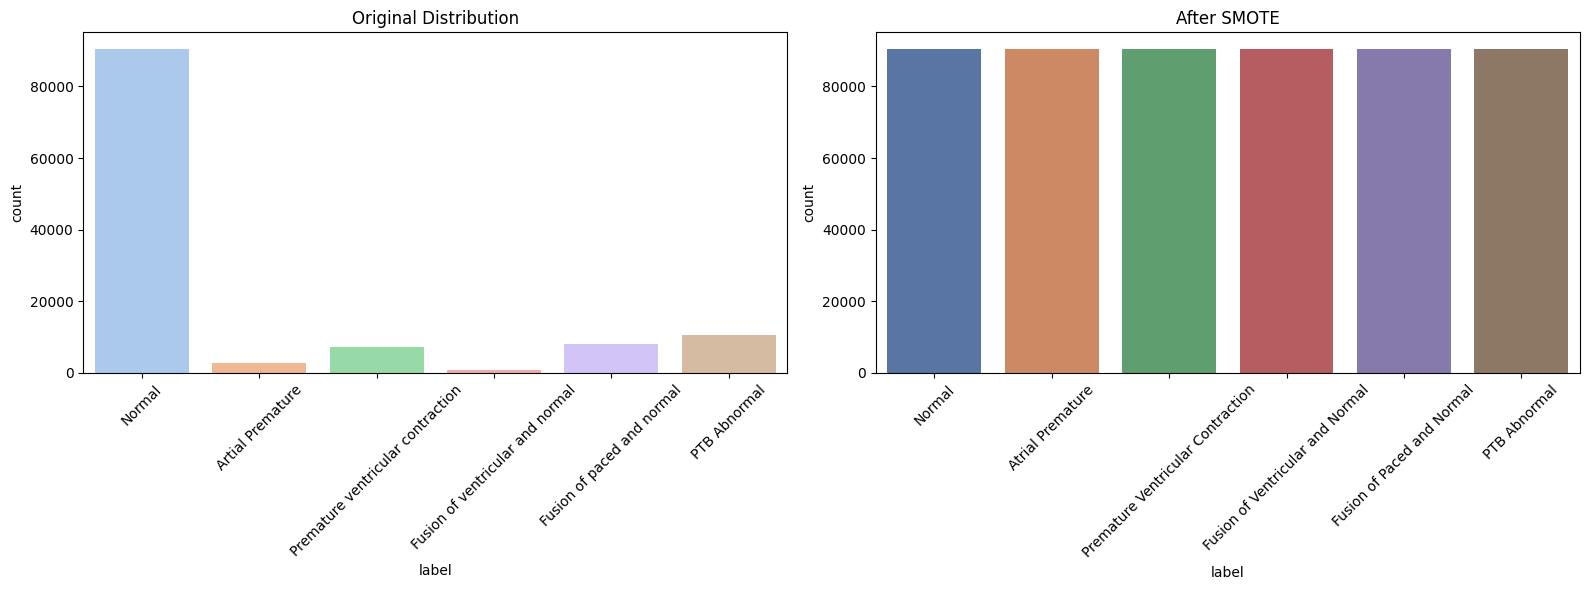

In [ ]:
# Plot Class Distribution
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(x='label', data=df_combined, ax=axs[0], palette='pastel')
axs[0].set_title('Original Distribution')
axs[0].tick_params(axis='x', rotation=45)

sns.countplot(x='label', data=df_resampled, ax=axs[1], palette='deep')
axs[1].set_title('After SMOTE')
axs[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png', bbox_inches='tight')
plt.show()

In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_resampled.iloc[:, :187])

# Prepare features and labels
X = X_scaled.reshape(-1, 187, 1).astype(np.float32)
y = to_categorical(df_resampled['class'].values, num_classes=6)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=config.seed
)

In [ ]:
# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def call(self, x):
        seq_len = tf.shape(x)[1]
        d_model = x.shape[-1]
        position = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) *
                          -(tf.math.log(10000.0) / tf.cast(d_model, tf.float32)))
        sin_term = tf.sin(position * div_term)
        cos_term = tf.cos(position * div_term)
        pos_enc = tf.concat([sin_term, cos_term], axis=-1)
        pos_enc = pos_enc[:, :d_model]
        pos_enc = pos_enc[tf.newaxis, ...]
        return x + pos_enc

# Improved Transformer Model
def improved_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(128, kernel_size=3, padding='same', activation='relu',
               kernel_regularizer=l2(1e-4))(inputs)  # Increased filters
    x = BatchNormalization()(x)
    x = PositionalEncoding()(x)

    # Transformer Block 1
    attn_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)  # Increased heads
    attn_output = Dropout(0.2)(attn_output)
    x = LayerNormalization()(x + attn_output)

    ffn = tf.keras.Sequential([
        Dense(256, activation=gelu, kernel_regularizer=l2(1e-4)),  # Increased units
        Dropout(0.3),
        Dense(128, kernel_regularizer=l2(1e-4))
    ])
    x = LayerNormalization()(x + ffn(x))

    # Transformer Block 2
    attn_output2 = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    attn_output2 = Dropout(0.2)(attn_output2)
    x = LayerNormalization()(x + attn_output2)

    x = LayerNormalization()(x + ffn(x))

    # Additional Transformer Block
    attn_output3 = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    attn_output3 = Dropout(0.2)(attn_output3)
    x = LayerNormalization()(x + attn_output3)
    x = LayerNormalization()(x + ffn(x))

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation=gelu, kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Create and Compile Model
input_shape = (187, 1)
num_classes = 6  # 5 MIT-BIH + 1 PTB Abnormal
model = improved_transformer_model(input_shape, num_classes)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 187, 128)  │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 187, 128)  │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 187, 128)  │          0 │ batch_normalizat… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 187, 128)  │    263,808 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 187, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 187, 128)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 187, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 187, 128)  │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 187, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 187, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 187, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 187, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 187, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 128)  │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 877,190 (3.35 MB)

 Trainable params: 876,934 (3.35 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10, restore_best_weights=True
)

def lr_scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
# Save the trained model to an H5 file
model.save('my_model.h5')

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,  # Increased for better convergence
    batch_size=1500,  # Larger batch size
    callbacks=[early_stopping, lr_callback]
)

NameError: name 'X_train' is not defined

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10, restore_best_weights=True
)

def lr_scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,  # Increased for better convergence
    batch_size=1200,  # Larger batch size
    callbacks=[early_stopping, lr_callback]
)

Epoch 1/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 471s 554ms/step - accuracy: 0.9765 - loss: 0.1081 - val_accuracy: 0.9807 - val_loss: 0.0942 - learning_rate: 5.0000e-04
Epoch 2/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 471s 554ms/step - accuracy: 0.9814 - loss: 0.0885 - val_accuracy: 0.9857 - val_loss: 0.0734 - learning_rate: 5.0000e-04
Epoch 3/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 471s 554ms/step - accuracy: 0.9843 - loss: 0.0749 - val_accuracy: 0.9866 - val_loss: 0.0662 - learning_rate: 5.0000e-04
Epoch 4/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 502s 553ms/step - accuracy: 0.9869 - loss: 0.0641 - val_accuracy: 0.9895 - val_loss: 0.0559 - learning_rate: 5.0000e-04
Epoch 5/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 496s 546ms/step - accuracy: 0.9875 - loss: 0.0584 - val_accuracy: 0.9900 - val_loss: 0.0508 - learning_rate: 5.0000e-04
Epoch 6/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 508s 554ms/step - accuracy: 0.9891 - loss: 0.0506 - val_accuracy: 0.9907 - val_loss: 0.0448 - learning_rate: 5.0000e-04
Epoch 7/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 

ValueError: The output of the `schedule` function should be a float. Got: 0.00047561473911628127

In [ ]:
# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

3398/3398 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.9919 - loss: 0.0317
Test Accuracy: 99.26%


In [ ]:
# Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png', bbox_inches='tight')
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

def model_a(input_shape, num_classes):
    model = Sequential()

    # Conv1D Layer 1
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same',
                     input_shape=input_shape))  # Output: (None, 187, 32)

    # Conv1D Layer 2
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))  # Output: (None, 187, 64)

    # Conv1D Layer 3
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))  # Output: (None, 187, 128)

    # Max Pooling
    model.add(MaxPooling1D(pool_size=2))  # Output: (None, 93, 128)

    # Dropout
    model.add(Dropout(0.3))  # Regularization

    # Flatten
    model.add(Flatten())  # Output: (None, 93*128 = 11904)

    # Dense Layers
    model.add(Dense(512, activation='relu'))  # Output: (None, 512)
    model.add(Dense(1024, activation='relu'))  # Output: (None, 1024)

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))  # Output: (None, 6)

    return model

# Create and Compile Model A
input_shape = (187, 1)  # ECG signal with 187 timesteps, 1 channel
num_classes = 6  # 5 MIT-BIH + 1 PTB Abnormal
model_a_instance = model_a(input_shape, num_classes)

model_a_instance.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_a_instance.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 187, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 187, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 187, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     6,095,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,657,862 (25.40 MB)

 Trainable params: 6,657,862 (25.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_a=model_a_instance.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,  # Increased for better convergence
    batch_size=512)  # Larger batch size

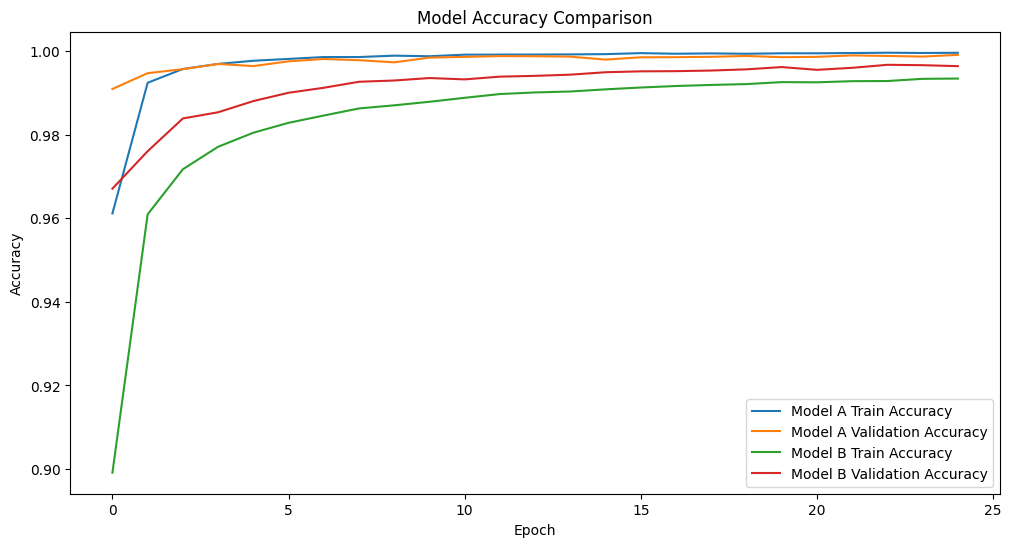

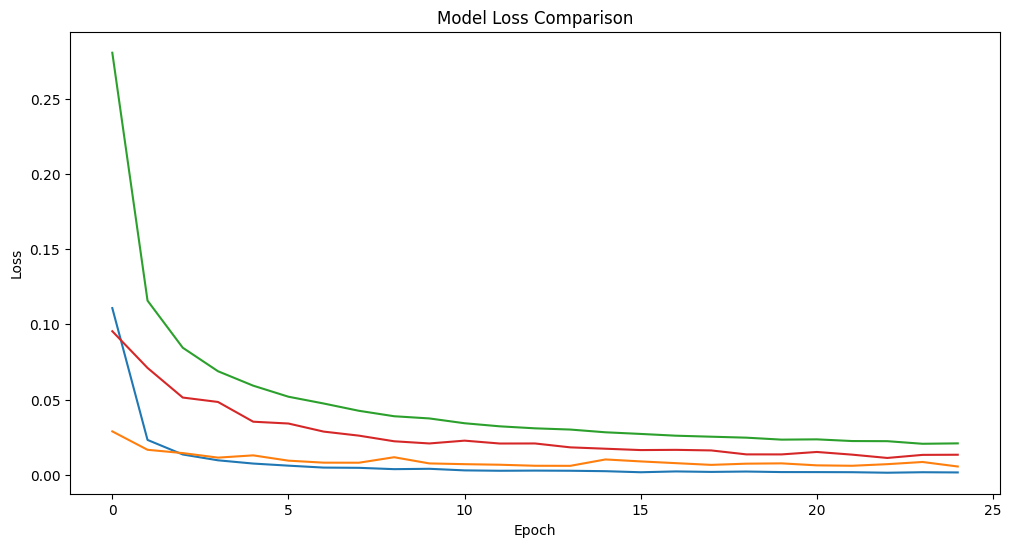

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history_a.history['accuracy'], label='Model A Train Accuracy')
plt.plot(history_a.history['val_accuracy'], label='Model A Validation Accuracy')
plt.plot(history_b.history['accuracy'], label='Model B Train Accuracy')
plt.plot(history_b.history['val_accuracy'], label='Model B Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.savefig('model_accuracy_comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_a.history['loss'], label='Model A Train Loss')
plt.plot(history_a.history['val_loss'], label='Model A Validation Loss')
plt.plot(history_b.history['loss'], label='Model B Train Loss')
plt.plot(history_b.history['val_loss'], label='Model B Validation Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
test_loss_a, test_accuracy_a = model_a_instance.evaluate(X_test, y_test)
print(f"Test Accuracy for Model A: {test_accuracy_a*100:.2f}%")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Bidirectional, LSTM, GlobalAveragePooling1D, BatchNormalization

def model_b(input_shape, num_classes):
    model = Sequential()

    # Conv1D Layer 1
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
                     input_shape=input_shape))  # Output: (None, 187, 128)

    # Conv1D Layer 2
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))  # Output: (None, 187, 128)

    # Max Pooling 1
    model.add(MaxPooling1D(pool_size=10))  # Output: (None, 18, 128)

    # Dropout 1
    model.add(Dropout(0.3))  # Regularization

    # Conv1D Layer 3
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))  # Output: (None, 18, 128)

    # Conv1D Layer 4
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))  # Output: (None, 18, 128)

    # Max Pooling 2
    model.add(MaxPooling1D(pool_size=5))  # Output: (None, 3, 128)

    # Dropout 2
    model.add(Dropout(0.3))  # Regularization

    # Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Output: (None, 3, 256)

    # Conv1D Layer 5
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))  # Output: (None, 3, 128)

    # Conv1D Layer 6
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))  # Output: (None, 3, 128)

    # Global Average Pooling
    model.add(GlobalAveragePooling1D())  # Output: (None, 128)

    # Batch Normalization
    model.add(BatchNormalization())  # Output: (None, 128)

    # Dense Layer 1
    model.add(Dense(256, activation='relu'))  # Output: (None, 256)

    # Dropout 3
    model.add(Dropout(0.3))  # Regularization

    # Dense Layer 2
    model.add(Dense(128, activation='relu'))  # Output: (None, 128)

    # Dropout 4
    model.add(Dropout(0.3))  # Regularization

    # Dense Layer 3
    model.add(Dense(64, activation='relu')) # Output: (None, 64)

    # Dropout 5
    model.add(Dropout(0.3))  # Regularization

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))  # Output: (None, 6)

    return model

# Create and Compile Model B
input_shape = (187, 1)  # ECG signal with 187 timesteps, 1 channel
num_classes = 6  # 5 MIT-BIH + 1 PTB Abnormal
model_b_instance = model_b(input_shape, num_classes)

model_b_instance.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_b_instance.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 187, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 187, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 18, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 18, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 3, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 3, 128)         │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 3, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 634,310 (2.42 MB)

 Trainable params: 634,054 (2.42 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
history_b=model_b_instance.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,  # Increased for better convergence
    batch_size=512)  # Larger batch size

In [ ]:
test_loss_b, test_accuracy_b = model_b_instance.evaluate(X_test, y_test)
print(f"Test Accuracy for Model B: {test_accuracy_b*100:.2f}%")

3398/3398 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step


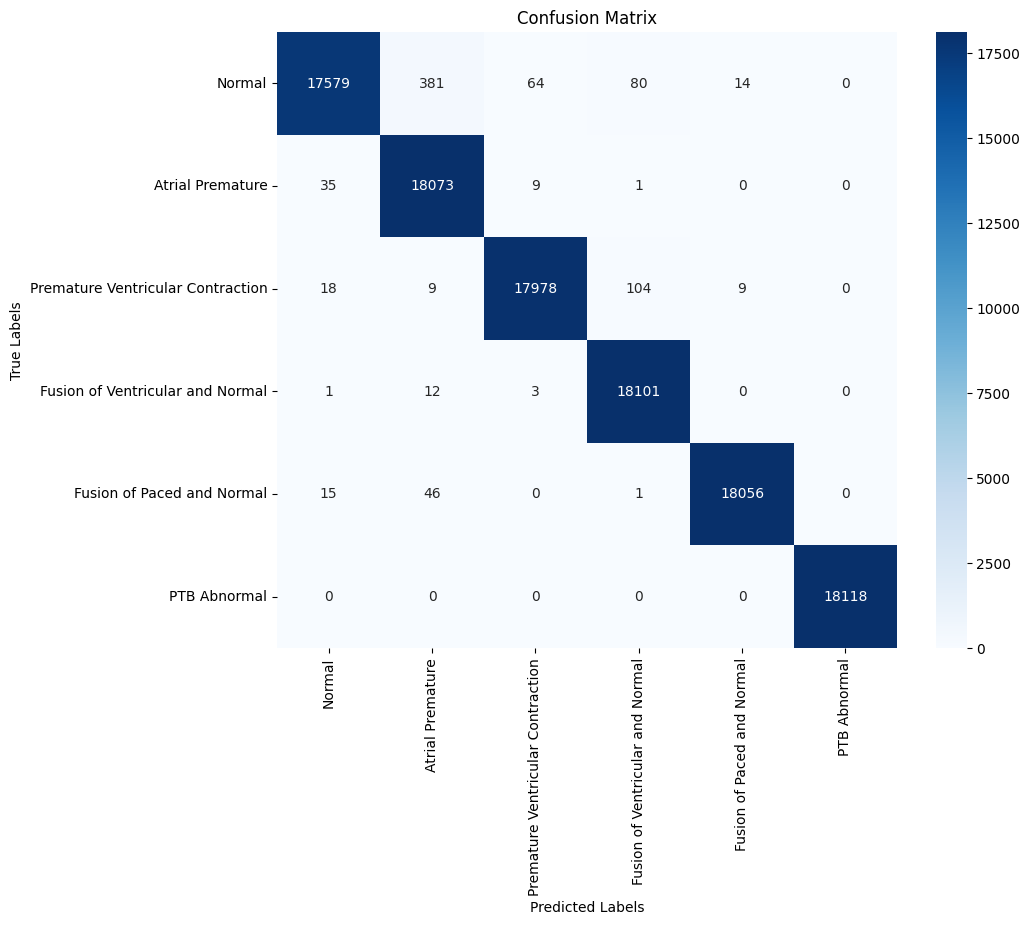

In [ ]:
# Confusion Matrix and Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=id_to_label.values(), yticklabels=id_to_label.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=id_to_label.values(), digits=4))

Classification Report:
                                   precision    recall  f1-score   support

                           Normal     0.9961    0.9703    0.9830     18118
                 Atrial Premature     0.9758    0.9975    0.9865     18118
Premature Ventricular Contraction     0.9958    0.9923    0.9940     18118
 Fusion of Ventricular and Normal     0.9898    0.9991    0.9945     18117
       Fusion of Paced and Normal     0.9987    0.9966    0.9977     18118
                     PTB Abnormal     1.0000    1.0000    1.0000     18118

                         accuracy                         0.9926    108707
                        macro avg     0.9927    0.9926    0.9926    108707
                     weighted avg     0.9927    0.9926    0.9926    108707

